# Explicit linear SC solver using the ZERO DPP tier 3 detuned IOTA lattice with 1st order maps

**September 12, 2016: Added the notebook to the IOPTICS repo for further RadiaSoft studies using the Radiasoft [Jupyter Server](https://jupyter.radiasoft.org/)** 

This notebook looks at the detuned IOTA 8.2 lattice (dQ = -0.03) WITH space charge, designed without momentum spread. The lattice file is `zerodpp_soft_nll0pt2_1IO_dQ_03.madx`. With the newest version of Synergia installed, the nonlinear lens propagator should also no longer lose particles due to improper kicks being calculated for particles at small y values.

*NOTE: Lattice files may be found in the corresponding [ioptics](https://github.com/radiasoft/ioptics) repository.*

**Basic Simulation Parameters**

- IOTA v8.2 lattice with 1 integrable optics drift section and nonlinear element - t=0.2
- Sextupole strengths set to zero
- Full CHEF propagation through nonlinear element - 1st order propagation elsehwere
- Each element in the lattice is sliced into 4 segments for computing dynamics.

**Basic Beam Parameters**

- 2.5 MeV proton beam
- KV distribution consisting of a delta function in $H_0$ with $H_0 = 4.0$ mm-mrad
- Current set to 0.43754 mA as a best-fit working point for behavior of the invariants.

**Specific setup notes for use on jupyter.radiasoft.org** 

1. Either rsssynergia must be in your path, or it must be installed using pip -q install 
2. Adjust the `dir_66` and `dir_82` values in the 3rd code block to match the location of your lattice files.

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
del sys.argv[1:]
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
import tables
from mpi4py import MPI

In [2]:
try:
    import rssynergia
except ImportError:
    !pip -q install git+git://github.com/radiasoft/rssynergia

from rssynergia.base_diagnostics import utils
from rssynergia.base_diagnostics import read_bunch
from rssynergia.base_diagnostics import workflow
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import latticework
from rssynergia.base_diagnostics import basic_calcs
from rssynergia.base_diagnostics import pltbunch
from rssynergia.base_diagnostics import elliptic_sp
from rssynergia.base_diagnostics import singleparticle
from rssynergia.base_diagnostics import options
from rssynergia.standard import standard_beam6d
from rssynergia.elliptic import elliptic_beam6d
import synergia
import synergia_workflow

## Major beam and lattice parameters

I've separated these at the top of the notebook to improve clarity. These represent fundamental user parameters and are defined with all-caps names. Some of these are immutable, or require using a different lattice file for the changes to carry over appropriately. They have been separated from the other user-modifiable parameters.

In [3]:
#========= Immutable Lattice Parameters - changing these requires a different lattice file =====================
TVAL = 0.2
CVAL = 0.01
NL_TUNE = 0.3 #Tune through NL insert
L_NL_INSERT = 1.8 #length of NL insert


#========= Some primary beam and lattice parameters - user modifiable =====================
#Lattice directories
DIR_66 = '/home/vagrant/jupyter/ioptics/ioptics/lattices/Iota6-6/'
DIR_82 = '/home/vagrant/jupyter/ioptics/ioptics/lattices/Iota8-2/'

#Beam Parameters
G_EMIT = 4.e-6 #H0-value for the beam
CURRENT = 0.43754576288579633*1.e-3
DPOP = 0.0 #no delta p/p

#Grid and Solver Parameters
GRID_X = 32
GRID_Y= 32
GRID_Z = 1
N_PPC = 10
N_STEPS_PER_ELEMENT = 4
ORDER = 1 #solver order - 1 for linear mapsturns = 10
TURNS = 128

## Load options and lattices

In [4]:
#load options for SC_test
from SC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [5]:
#================== Load the lattice =======================

lattices = {}
lattices['t1_1IO_66'] = DIR_66 + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
lattices['t3_1IO_66'] = DIR_66 + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice
lattices['t1_1IO_82_uncentered'] = DIR_82 + "lattice_1IO.madx" #uncentered tier1 8.2 lattice
lattices['t1_1IO_82'] = DIR_82 + "lattice_1IO_center.madx" #this is the new tier1 8.2 (zero current) lattice
lattices['t3_1IO_82'] = DIR_82 + "lattice_1IO_nll_center.madx" #this is the centerted t3 8.2 lattice

lattices['t1_1IO_82_dQ3'] = DIR_82 + "soft_lattice_1IO_dQ_03.madx" #t1 8.2 lattice adjusted for dQ = -0.03
lattices['t3_1IO_82_dQ3'] = DIR_82 + "soft_lattice_nll_1IO_dQ_03.madx" #t3 8.2 lattice adjusted for dQ = -0.03


lattices['t1_1IO_82_dQ3-zdpp'] = DIR_82 + "zerodpp_soft_lattice_1IO_dQ_03.madx" #ZERO DPP t3 8.2 lattice adjusted for dQ = -0.03
lattices['t3_1IO_82_dQ3-zdpp'] = DIR_82 + "zerodpp_soft_lattice_nll_1IO_dQ_03.madx" #ZERO DPP t3 8.2 lattice adjusted for dQ = -0.03
lattices['t3_0pt2_1IO_82_dQ3-zdpp'] = DIR_82 + "zerodpp_soft_nll0pt2_1IO_dQ_03.madx" #ZERO DPP t3 8.2 lattice adjusted for dQ = -0.03


In [6]:
#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("iota", lattices[keys])

In [7]:
reference_particle = lattice_dict['t1_1IO_66']['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()

#================== Setting up the options =======================
opts.gridx = GRID_X
opts.gridy = GRID_Y
opts.griz = GRID_Z

n_macro = N_PPC*opts.gridx*opts.gridy
name = 'test'

nsteps = len(lattice_dict['t1_1IO_82']['lattice'].get_elements())*N_STEPS_PER_ELEMENT

opts.macro_particles = n_macro
opts.steps = nsteps
opts.steps_per_element = N_STEPS_PER_ELEMENT
opts.map_order = ORDER


print >>logger, "output directory:", opts.output_dir


#==================== Set up space charge solver ==========================

#flag for space charge
opts.spacecharge = True
#opts.solver = "2dbassetti-erskine"
#opts.solver = "2dopen-hockney"
opts.solver = "2D-linear"

requested_stepper = opts.stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [gridx, gridy, gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #dummy communicator
    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,
        # nsigma
        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    elif solver == '2D-linear':
        coll_operator = synergia.collective.Space_charge_2d_kv()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#opts.use_maps = 'none'
#now set element type and construct stepper
print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)


#================== Setting up the stepper and lattice simulator =======================

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    
    for elem in current_lattice.get_elements():
        
        #apply forced diagnostics at the entrance and exit of the NL element for tune diagnostics
        if elem.get_name() == "nlr1" or elem.get_name() == "nlr2":
            elem.set_string_attribute('no_simplify', 'true')
            elem.set_string_attribute('force_diagnostics', 'true') 
        
        #set chef propagation for nllens only
        if elem.get_type() == 'nllens':
            elem.set_string_attribute("extractor_type", "chef_propagate")
    
    #current_lattice = lattice_dict[key]['lattice']
    lattice_dict[key]['stepper'] = latticework.generate_stepper(current_lattice,coll_operator, opts)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

Using space charge solver  2D-linear
Grid:  32  x  32  x  1
use maps for: none
requested_stepper: splitoperator
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn
Using split-operator stepper with  1376  steps/turn


### Verify lattice tunes and twiss parameters

In [8]:
print "For t1 v8.2 lattice:" + str(lattice_dict['t1_1IO_82']['lattice_simulator'].get_both_tunes())
print "For t3 v8.2 lattice:" + str(lattice_dict['t3_1IO_82']['lattice_simulator'].get_both_tunes())
print "For zerodpp detuned t1 v8.2 lattice:" + str(lattice_dict['t1_1IO_82_dQ3-zdpp']['lattice_simulator'].get_both_tunes())
print "For zerodpp detuned t3 v8.2 lattice:" + str(lattice_dict['t3_1IO_82_dQ3-zdpp']['lattice_simulator'].get_both_tunes())
print "For zerodpp 0pt2 detuned t3 v8.2 lattice:" + str(lattice_dict['t3_0pt2_1IO_82_dQ3-zdpp']['lattice_simulator'].get_both_tunes())

For t1 v8.2 lattice:(0.30007507878938977, 0.3000355421087715)
For t3 v8.2 lattice:(0.4026532305504392, 0.30003554210877154)
For zerodpp detuned t1 v8.2 lattice:(0.33458666515512636, 0.33130483952873224)
For zerodpp detuned t3 v8.2 lattice:(0.3637815944824564, 0.33130483952873224)
For zerodpp 0pt2 detuned t3 v8.2 lattice:(0.3895427136352142, 0.33130483952873224)


/home/vagrant/.pyenv/versions/2.7.10/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


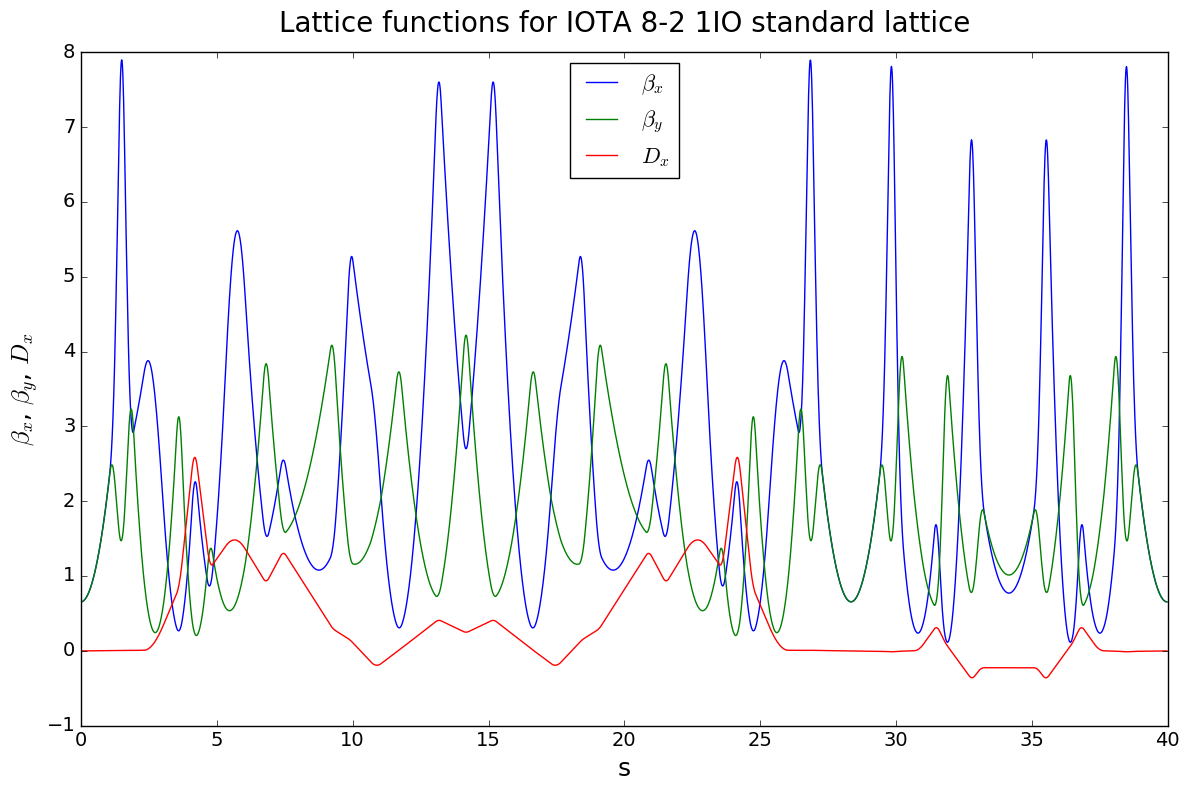

In [9]:
opts.save = False
opts.lattice_name = 'IOTA 8-2 1IO standard lattice'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_1IO_82']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

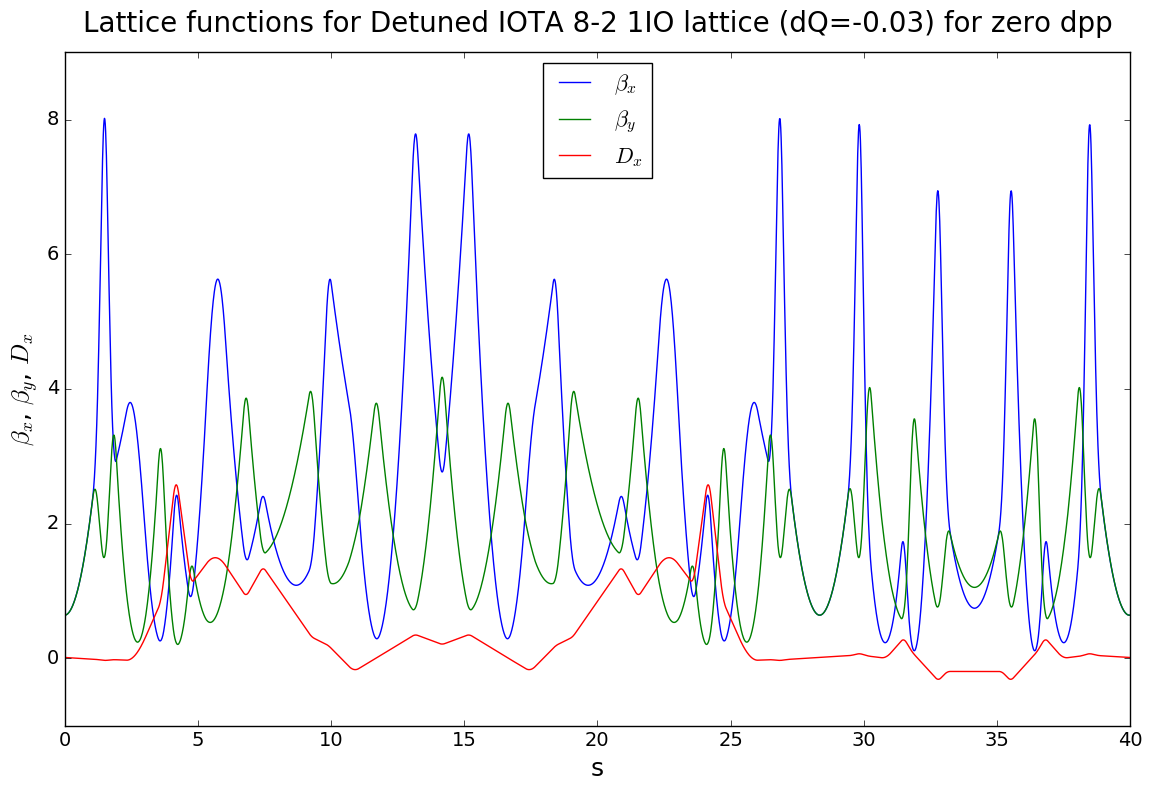

In [10]:
opts.save = False
opts.lattice_name = 'Detuned IOTA 8-2 1IO lattice (dQ=-0.03) for zero dpp'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_1IO_82_dQ3-zdpp']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82_dQ3-zdpp']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

## Construct the beam and propagate it

In [11]:
opts.lattice = lattice_dict['t3_0pt2_1IO_82_dQ3-zdpp']['lattice']
opts.lattice_simulator = lattice_dict['t3_0pt2_1IO_82_dQ3-zdpp']['lattice_simulator']
opts.stepper = lattice_dict['t3_0pt2_1IO_82_dQ3-zdpp']['stepper']

In [12]:
def dQ_SC_Gauss(N,emit,ref):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


def dQ_SC_KV(N,emit,ref):
    '''Return dQsc for a KV beam if given normalized emittance (2x that of Gaussian)'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(2*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ

g_emit = G_EMIT #value of H0 for the beam - with no NL insert, this is 1/2 the total emittance of the beam
n_emit = basic_calcs.calc_normalized_emittance(g_emit,opts.beta,opts.gamma)

current = CURRENT
l_IOTA = 39.968229715800064 #length of lattice
rp_perlength = current/(reference_particle.get_beta()*scipy.constants.c*scipy.constants.e)
n_particles = rp_perlength*l_IOTA

dQ = dQ_SC_Gauss(n_particles,n_emit,reference_particle) #calc dQsc_x
dQ_KV = dQ_SC_KV(n_particles,n_emit,reference_particle) #calc dQsc_x

print "Assume a normalized total emittance of {} mm-mrad.".format(n_emit*1.e6)
print "At {} mA current, # of protons filling ring is {:e} or {:e} p+/cm.".format(current*1.e3,n_particles,n_particles/(100.*l_IOTA))
print "Corresponding space charge tune shift in x is {} for a Gaussian distribution".format(dQ)
print "Corresponding space charge tune shift in x is {} for KV distribution".format(dQ_KV)

Assume a normalized total emittance of 0.292192796636 mm-mrad.
At 0.437545762886 mA current, # of protons filling ring is 4.997507e+09 or 1.250370e+06 p+/cm.
Corresponding space charge tune shift in x is -0.0286173639128 for a Gaussian distribution
Corresponding space charge tune shift in x is -0.0572347278256 for KV distribution


#### A few notes on distributions for clarity

Note, for the kV-like distribution in coordinate space, the RMS value in x/y is 1/2 the maximum value. That is, in coordinate space, $\sigma_w = 0.5 w_{max}$. For the Gaussian distribution in momentum space, the RMS value is simply the standard deviation ($\sigma_w = \sigma_{p_w}$). The RMS emittance of the bunch (geometric) is then the product of these two values $\epsilon_w = \sigma_w \times \sigma_{p_w}$. 

Thus, we have $\epsilon_w = 0.5 w_{max} \sigma_{p_w}$. So if we specify a maximum coordinate (e.g. $x_{max}$), then we can define $\sigma_{p_w} = 2 \epsilon_w / w_{max}$

For a beam not at a waist, the beam should have a coordinate rotation applied by the twiss parameter matrix in each plane, but since we are injecting at beam waists we don't have to worry about this.

*Defining $x_{max}$*. This follows from the convention of defining $\epsilon_{x} = \sigma_x^2/\beta_x$. For a KV-like distribution in coordinate space, we can relate the maximum x value to the RMS via $\sigma_x = \sqrt{2}/2 x_{max}$. Thus, we have $x_{max} = \sqrt{2 \beta_x \epsilon_x}$.


In [13]:

#======================= Now setup the bunch and other related options =====================
#Can compute theoretical lattice functions for perfect drift
opts.t = TVAL
opts.c = CVAL
opts.new_tune = NL_TUNE
opts.lnll = L_NL_INSERT

#Alternatively, we can account for asymmetries in the lattice by grabbing these values directly
vals = latticework.get_starting_lf(lattice_dict['t1_1IO_82_dQ3-zdpp']['lattice_simulator'])

opts.betae = vals[0]
opts.alphae = 0
opts.beta0 = vals[0]

opts.dpop = DPOP

rp_perlength = current/(opts.beta*constants.c*constants.e)
bunch_length = opts.lattice.get_length() #effective bunch length is iota lattice length
opts.real_particles = rp_perlength*bunch_length


opts.emit = g_emit #Match using the geometric emittance
opts.emits = [opts.emit]
opts.stdz = bunch_length/10.


if myrank == 0:
    
    #construct a bunch and make sure to add longitudinal momentum variation
    particles = elliptic_beam6d.toyellipticalbeam6D(opts)

    for index in range(len(opts.emits)):
        bunch = particles[index]
        initialH,initialI = elliptic_sp.toy_calc_bunch_H(bunch,opts)
        bunch_mean = np.mean(initialH)
        bunch_std = np.std(initialH)
        bunch_var = (bunch_std/bunch_mean)*100
        print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
        #now add longitudinal momentum variation
        #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
        bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
        bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p
    
    particles_file = '{}ppc{:.3f}mA_4mm_2Dlinear_ellipticKV_bunch_dQ03.txt'.format(N_PPC,current*1.e3)
    np.savetxt(particles_file,bunch)         #write the bunch to a text file


bucket_length = bunch_length
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

Initial starting lattice functions: betax = 0.639101883937, betay = 0.638680938104, alphax = -0.000885043803234, alphay = 0.00245708709423
Constructed bunch with 10240 macroparticles, having mean H: 4e-06 and std: 3.69719199038e-14%
Loading Synergia particles from txt file:  10ppc0.438mA_4mm_2Dlinear_ellipticKV_bunch_dQ03.txt
Read  10240  particles


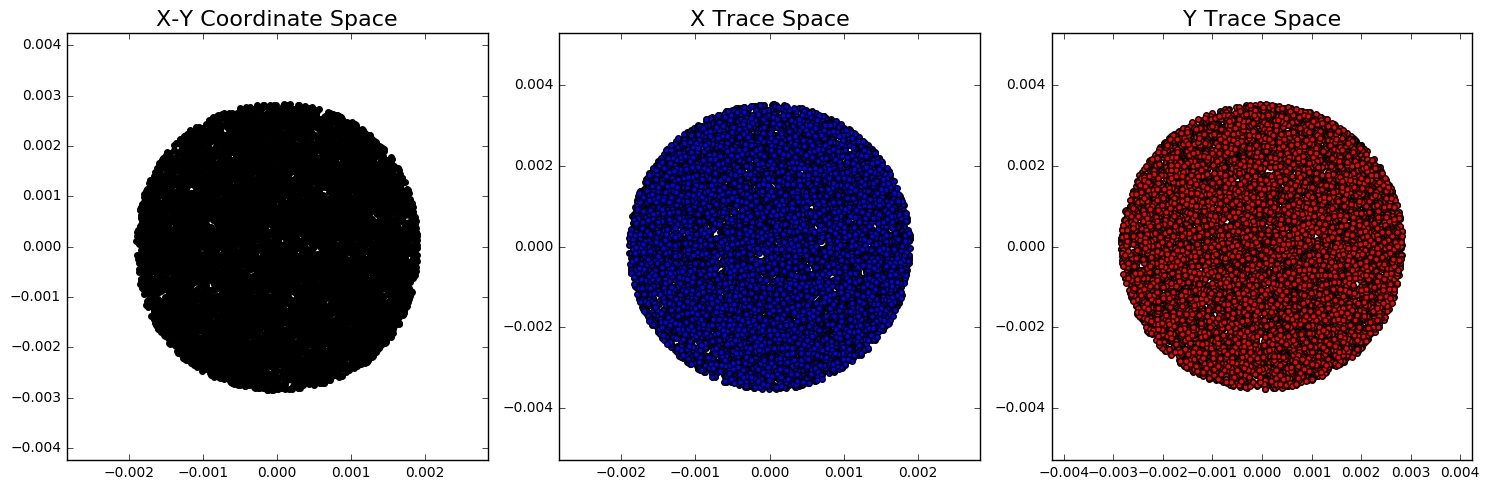

/home/vagrant/.pyenv/versions/2.7.10/lib/python2.7/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=-0.0
  'bottom=%s, top=%s') % (bottom, top))


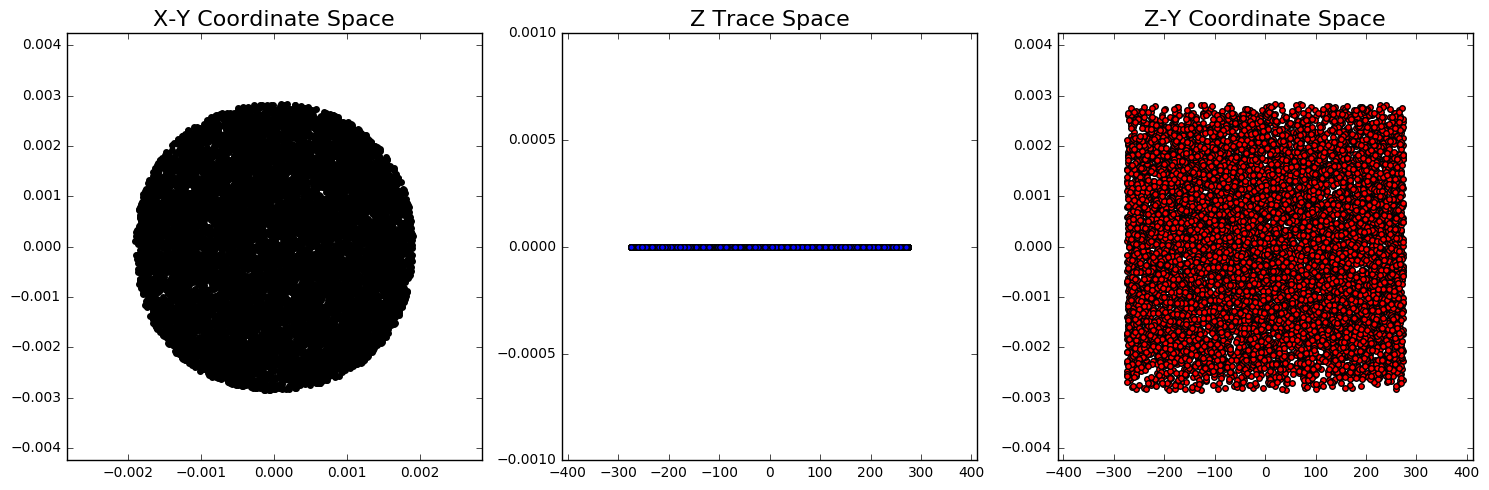

In [14]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

Quickly look at bunch properties.

In [15]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 0.959424582396 mm
rms envelope y: 1.4346926823 mm
maximum x value is : 1.89357878264 mm
maximum y value is : 2.82945881366 mm
rms beta x: 0.540037381566
rms beta y: 0.806938603618
geometric emittance x: 1.70450335611 mm-mrad
geometric emittance y: 2.55080508407 mm-mrad
normalized emittance x: 0.124510900625 mm-mrad
normalized emittance y: 0.186331717797 mm-mrad
mean of xp^2 : 3.15626920339e-06
mean of yp^2 : 3.16108942197e-06
total geometric emittance x: 6.63961556823 mm-mrad
total geometric emittance y: 9.92124697256 mm-mrad


In [16]:
outputdir = "10ppc-forced-{}turns-zerodpp-1storderIOTA-LKV-{:.3}mA-4mm".format(TURNS,current*1.e3)
workflow.make_path(outputdir)
opts.output_dir = outputdir
opts.relpath = opts.output_dir

bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#add forced particle diagnostics
bunch_simulator.add_per_forced_diagnostics_step(synergia.bunch.Diagnostics_particles("forced_part.h5",0,0, opts.output_dir))

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [17]:
opts.turns = TURNS
opts.checkpointperiod = 10
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(opts.stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Analysis

For the plots below, uncomment the `fig.savefig()` commands to generate PDF (or jpg) files for each plot.

### Analysis - Beam Envelopes

In [19]:
from rssynergia.base_diagnostics import diagplot

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

#we want to plot turn 0 and turn 100 on the same plot, so we should separate these specifically
interval = opts.steps 
xstd_0 = xstd[:interval]
xstd_2 = xstd[1*interval:2*interval]
xstd_end = xstd[-1*interval:] 

ystd_0 = ystd[:interval]
ystd_end = ystd[-1*interval:] 

#We can use the same s value for each plot
sval_0 = xmaster[:interval]

num_turns=opts.turns

AttributeError: 'module' object has no attribute 'openFile'

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,xstd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,xstd_end*1.e3,'g-',alpha=0.7, label='Turn {}'.format(num_turns)) #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_x$ over {} turns".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = '1storder_beam_envelope_x_compare_{}turns.pdf'.format(num_turns)
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,ystd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,ystd_end*1.e3,'g-',alpha=0.7, label='Turn {}'.format(num_turns)) #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_y$ over {} turns".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_y$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = '1storder_beam_envelope_y_compare_{}turns.pdf'.format(num_turns)
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

### Analysis - Bunch Properties

In [ ]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [ ]:
basic_calcs.calc_properties(myBunch,reference_particle)

In [ ]:
files = elliptic_sp.get_file_list(opts)
twiss = twiss = elliptic_sp.get_toy_twiss(opts)

rms_table = []

for inputfile in files:
    fn = inputfile[-7:-3]
    
    parts = elliptic_sp.get_particles(inputfile)[1]
    header= {}
    header['s_val'] = 0.
    #norm_coords = elliptic_sp.normalized_coordinates(header, part_array, twiss)
    
    x_rms = basic_calcs.get_rms_envelope('x',parts)
    y_rms = basic_calcs.get_rms_envelope('y',parts)
    
    rms_table.append((int(fn),x_rms,y_rms))
    
    #print "File {} : xrms = {:.2f} mm and yrms = {:.2f} mm".format(fn, x_rms*1.e3, y_rms*1.e3)
    
rms_array = np.asarray(rms_table)

In [ ]:
num_turns = rms_array.shape[0]-1

fig = plt.figure(figsize = (8,6))
plt.subplot(1,1,1)
ax = plt.gca()

ax.plot(rms_array[:,0],rms_array[:,1], label = '$x_{rms}$')
ax.plot(rms_array[:,0],rms_array[:,2], label = '$y_{rms}$')

axtitle = "Beam envelope evolution over {} turns with KV beam".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("Turn Number",fontsize=14)
ax.set_ylabel("rms beam size [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,num_turns])
ax.legend(loc='best')
sv_title = '1storder_KV_2D-LinearKV_{}turns_{:.3}mA.pdf'.format(num_turns,current*1.e3)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight')


plt.show()

## Analysis - Invariants

In [ ]:
opts.num = 1
opts.ID = 10
opts.norm = False
opts.variance = 0.1
opts.lost = True
opts.lattice_name = '2DH - Iota 8-2 dQ = -0.03'
opts.save = False
elliptic_sp.toy_plot_elliptic_invariant(opts)

In [ ]:
opts.num = 2
opts.ID = 100
opts.norm = False
opts.variance = 0.1
opts.lost = True
opts.lattice_name = '2DH - Iota 8-2 dQ = -0.03'
opts.save = False
elliptic_sp.toy_plot_elliptic_invariant(opts)

In [ ]:
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
lostlist = elliptic_sp.get_lost_particle_list(opts)
lost = lostlist.any()

hFull = {}
iFull = []

for index,outfile in enumerate(files):
    if index%50 == 0:
        print "Calculating invariants for file {}".format(index)
    
    if lost.any():
        header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost, lostlist)
    else:
        header, particles = elliptic_sp.get_particles(outfile, lost)

    #print particles
    hVals, iVals = elliptic_sp.toy_calc_bunch_H(particles, opts)
    
    #print "The length of the the invariants array for file 1 is {}".format(len(hVals))
    
    hFull[index] = np.asarray(hVals)
    iFull.append(np.asarray(iVals))
    
iFull = np.asarray(iFull)

In [ ]:
turns = np.asarray([ind for ind in hFull])
hAVG = np.asarray([np.mean(hFull[ind]) for ind in hFull])
hSTD = np.asarray([np.std(hFull[ind]) for ind in hFull])
hSTD_Frac = (hSTD/hAVG)*100.


#Compute per particle averages and STDs, then average and weight those, rather than considering the entire ensemble. 
#This is a more general approach and ignores that the 2nd invariant is not equal for all particles in the distribution.

iAVG = np.asarray([np.mean(iFull[:,ind]) for ind in range(iFull.shape[1])]) #avg I over all turns for each particle
iSTD = np.asarray([np.std(iFull[:,ind]) for ind in range(iFull.shape[1])]) #std I over all turns for each particle
iSTD_FRAC = (iSTD/iAVG)*100.

print "The mean standard deviation in I for individual particles is {}".format(np.mean(iSTD_FRAC))

#Alternative approach: construct initial spread and substract that out for every turn
iAVG_initial = np.mean(iFull[0,:])
iSTD_initial = np.std(iFull[0,:])

iAVG_turns = np.asarray([np.mean(iFull[ind,:]) for ind in range(iFull.shape[0])])
iSTD_turns = np.asarray([np.std(iFull[ind,:])-iSTD_initial for ind in range(iFull.shape[0])])
iSTD_turns_frac = (iSTD_turns/iAVG_turns)*100.
#iAVG = np.asarray([np.mean(iFull[ind]) for ind in iFull])
#iSTD = np.asarray([np.std(iFull[ind]) for ind in iFull])
#iSTD_Frac = (iSTD/iAVG)*100.

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()

ax.plot(turns, hAVG*1.e6)

ax.set_xlim([0,num_turns])
#ax.set_ylim([0,0.0015])
ax.set_xlabel('Turn #', fontsize=16)
ax.set_ylabel('Average $H$ [mm-mrad]', fontsize=16)
ax.set_title('Average $H$ - Linear KV - 4mm-mrad KV - IOTA 8.2. DQ-0.03',fontsize=18, y=1.02)

sv_title = 'AVG_H_IOTA8-2_dQ03_{:.3}mA.pdf'.format(current*1.e3)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight') 

plt.show()
  

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()

ax.plot(turns, hSTD*1.e6)

ax.set_xlim([0,num_turns])
#ax.set_ylim([0,0.0015])
ax.set_xlabel('Turn #', fontsize=16)
ax.set_ylabel('$\sigma H$ [mm-mrad]', fontsize=16)
ax.set_title(' $\sigma H$ - Linear KV - 4mm-mrad KV - IOTA 8.2. DQ-0.03',fontsize=18, y=1.02)

sv_title = 'STD_H_IOTA8-2_dQ03_10ppc_{:.3}mA.pdf'.format(current*1.e3)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight') 

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()

ax.plot(turns, hSTD_Frac)

ax.set_xlim([0,num_turns])
#ax.set_ylim([0,0.0015])
ax.set_xlabel('Turn #', fontsize=16)
ax.set_ylabel('$\sigma H$ [%]', fontsize=16)
ax.set_title(' $\sigma H$ - Linear KV - 4mm-mrad KV - IOTA 8.2. DQ-0.03',fontsize=18, y=1.02)

sv_title = 'STD_H_FRAC_IOTA8-2_dQ03_10ppc_{:.3}mA.pdf'.format(current*1.e3)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight') 

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()

ax.plot(turns, iSTD_turns_frac)

ax.set_xlim([0,num_turns])
#ax.set_ylim([0,0.0015])
ax.set_xlabel('Turn #', fontsize=16)
ax.set_ylabel('$\sigma I$ [%]', fontsize=16)
ax.set_title(' $\sigma I$ - Linear KV - 4mm-mrad KV - IOTA 8.2. DQ-0.03',fontsize=18, y=1.02)

sv_title = 'STD_I_FRAC_IOTA8-2_dQ03_{:.3}mA.pdf'.format(current*1.e3)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight') 

plt.show()

In [ ]:
turnnums = ['00','01','02','03','04','05']

filelist = ["particles_00{}.h5".format(val) for val in turnnums]
#filelist[-1] = "particles_0100.h5" #force this one
path = os.path.join(os.getcwd(),opts.relpath)
pathlist = [os.path.join(path,fn) for fn in filelist]  #construct path list for files

opts.relpath = opts.output_dir
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
lost = elliptic_sp.get_lost_particle_list(opts)

if len(lost) > 0:
    #we have lost particles
    opts.lost = lost #store these in opts.lost
    lost = True #make lost a simple flag

hFull = {}
iFull = {}

for index,outfile in enumerate(pathlist):
    print "Calculating invariants for file {}".format(index)
    
    if lost:
        header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost,opts.lost)
    else:
        header, particles = elliptic_sp.get_particles(outfile, lost)

    #print particles
    hVals, iVals = elliptic_sp.calc_bunch_H(particles, opts)
    
    print "The length of the the invariants array for file 1 is {}".format(len(hVals))
    
    hFull[turnnums[index]] = np.asarray(hVals)
    iFull[turnnums[index]] = np.asarray(iVals)
    
    #hFull[index] = np.asarray(hVals)
    #iFull[index] = np.asarray(iVals)

## Analysis of particle tunes

#### Analysis of the bunch tune over many turns - FFT analysis

In [ ]:
def get_particle_coords(ID, num, opts):
    '''Return particle (human) coordinates for particle with ID over first num turns'''
    
    files = elliptic_sp.get_file_list(opts)
    twiss = elliptic_sp.get_toy_twiss(opts)

    part_array = []

    for index,outfile in enumerate(files[:num]):
        
        #if index%20 == 0:
            #print "Grabbing particle {} coordinates for file {}".format(ID,index)
    
        particle = elliptic_sp.get_one_particle(outfile,ID)
    
        if index ==0:
            part_array = particle
        else:
            part_array = np.vstack([part_array,particle])
            
    return part_array

def estimate_tune(x_c, t_s = 1):
    '''Estimate the tune using an FFT of particle coordinates'''
    
    num_used = len(x_c[t_s:])
    tv = np.arange(num_used)*1.0/num_used
    sp = np.fft.fft(x_c[t_s:])
    #plt.plot(tv,sp.real)


    smax = np.max(sp.real)
    m_ind = np.where(sp.real == smax)
    Q_guess =m_ind[0][0]*1./num_used
    if Q_guess > 0.5:
        Q_calc = 1.- Q_guess
    else:
        Q_calc = Q_guess
    #print "Maximum is at {}".format(Q_calc)
    return Q_calc

def estimate_tune_unwrap(x_c,px_c,t_s):
    '''Estimate the tune using a phase unwrap algorithm
    
    Inputs:
        -x_c = normalized spatial coordinate
        -px_c = normalized momentum cooridnate
        -t_s = starting turn value from the array of coordinates
    
    '''
    ang_norm = []
    for x,y in zip(x_c,px_c):
        if x > 0 and y > 0: #quandrant I
            ang_norm.append(np.arctan(y/x))
        elif x < 0 and y > 0: #quandrant II
            ang_norm.append(0.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))
        elif x < 0 and y < 0: #quadrant III
            ang_norm.append(np.pi + np.abs(np.arctan(y/x)))
        else: #quadrant IV
            ang_norm.append(1.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))

    #take diference between elements
    diff_ang = np.ediff1d(ang_norm)

    #adjust for wrapping by replacing positive values with 2pi-val
    dff_adjust = []
    for val in diff_ang:
        if val > 0:
            val = val - 2*np.pi
        dff_adjust.append(val)

    #now look at the last 50-80 turns
    #np.mean(dff_adjust[30:])
    t_s = 0
    meantune = -1*(np.mean(dff_adjust[t_s:]))/(2*np.pi)
    #print "{} is the mean tune for particle 0 after turn {}".format(meantune,t_s)
    return meantune

In [ ]:
num_tunes = 1000
lostlist = elliptic_sp.get_lost_particle_list(opts)
extra = np.where(lostlist<num_tunes-1)[0]
skip_indices = lostlist[extra]
#add extra #s in to account for the lost particles in the desired range
id_base = np.arange(num_tunes+len(skip_indices)) 
id_list = np.setxor1d(id_base,skip_indices) 

num_t = num_turns
tune_array = []
part_array = []

twiss = twiss = elliptic_sp.get_toy_twiss(opts)
header= {}
header['s_val'] = 0.
files = elliptic_sp.get_file_list(opts)[:num_t]

for index,inputfile in enumerate(files):
    #get all of the particles specifed by IDlist
    p_A = elliptic_sp.get_some_particles(inputfile,id_list)
    norm_coords = elliptic_sp.normalized_coordinates(header, p_A, twiss)
    if len(part_array) == 0:
        #if empty, then replace with norm_coords - first turn
        part_array = norm_coords
    else:
        part_array = np.vstack((part_array,norm_coords))
    
    
#reshape array to be indexable by ID number     
new_PA = part_array.reshape(num_t,len(id_list),4)

x_tune_array = []
y_tune_array = []
for ID in range(len(id_list)):
    x_tune_array.append(estimate_tune(new_PA[:,ID,0]))
    y_tune_array.append(estimate_tune(new_PA[:,ID,2]))

The tune spread is easier to observe using a histogram/distribution plot. Note that because we only examined 250 turns, our sampling is rather low, and as a result our resolution for something like a histogram is pretty bad.

In [ ]:
numBins = 12

#xtune
myVals, myBins = np.histogram(x_tune_array,numBins)
bincenters_x = 0.5*(myBins[1:]+myBins[:-1])
bin_width = 1.0*(myBins[1]-myBins[0])
myVals_norm_x = myVals/(np.max(myVals)*1.0)
#ytune
myVals, myBins = np.histogram(y_tune_array,numBins)
bincenters_y = 0.5*(myBins[1:]+myBins[:-1])
bin_width = 1.0*(myBins[1]-myBins[0])
myVals_norm_y = myVals/(np.max(myVals)*1.0)

In [ ]:
with mpl.style.context('rs_present'):
    
    #Set some matplotlib standards for plots 
    mpl.rcParams['figure.figsize'] = 8, 6
    
    fig = plt.figure()
    ax = fig.gca()
    
    ax.set_xlabel("Calculated Tunes over {} turns".format(num_turns), fontsize=14)
    ax.set_ylabel("Relative population", fontsize=14)
    
    ax.plot(bincenters_x,myVals_norm_x, label=r'Q$_x$')
    ax.plot(bincenters_y,myVals_norm_y, label=r'Q$_y$')
    
    ax.set_xlim([0.15,0.45])
    
    ax.set_title('Tune comparisons for 4mm-mrad Linear KV - IOTA 8.2. DQ-0.03',y=1.02)
    plt.legend()
    
    plt.show()
    
    sv_title = '1storder{}turns_x_y_tune_linearKV_dQ03.pdf'.format(num_turns)
    #fig.tight_layout()
    fig.savefig(sv_title,bbox_inches='tight') 
    #close the first display call
    #plt.close()
    
    #return fig #return the figure handle

#utils.plot_distribution(x_tune_array,10)

## Single turn phase advance from exit to entrance of nonlinear element

We should be able to ue linear normal forms here since the particles have left the nonlinear element at this point.

#### Tune in y plane

In [ ]:
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_sliced_twiss(opts.lattice_simulator)
phases_y1 = elliptic_sp.single_turn_phase_advance(files,twiss,dim='y',nParticles=10000,indices=[0,1],clockwise=True)
phases_y128 = elliptic_sp.single_turn_phase_advance(files,twiss,dim='y',nParticles=10000,indices=[126,127],clockwise=True)

In [ ]:
with mpl.style.context('rs_paper'):
    bincenters1, vals1 = utils.get_distribution(phases_y1,100)
    bincenters2, vals2 = utils.get_distribution(phases_y128,100)
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(bincenters1,vals1, label='turn 1')
    ax.plot(bincenters2,vals2, label='turn 128')
    ax.set_xlim([-0.001,0.001])
    ax.set_xlabel('Single turn phase advance in vertical plane')
    ax.set_title('Phase Unwrap for single turn with current {:.3} mA'.format(current*1.e3),y=1.01)
    ax.legend(loc='best')
    #plt.savefig('y_unwrap_turn1_128_{:.3}mA.pdf'.format(current*1.e3))
    fig.show()

In [ ]:
with mpl.style.context('rs_paper'):
    bincenters1, vals1 = utils.get_distribution(phases_y1,100)
    bincenters2, vals2 = utils.get_distribution(phases_y128,100)
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(bincenters1,vals1, label='turn 1')
    ax.plot(bincenters2,vals2, label='turn 128')
    ax.set_xlim([-0.001,0.001])
    ax.set_xlabel('Single turn phase advance in vertical plane')
    ax.set_title('Phase Unwrap for single turn with current {:.3} mA'.format(current*1.e3),y=1.01)
    ax.legend(loc='best')
    #plt.savefig('y_unwrap_turn1_128_{:.3}mA.pdf'.format(current*1.e3))
    fig.show()

#### Tune in x plane

In [ ]:
files = elliptic_sp.get_file_list(opts,'forced_part')
twiss = elliptic_sp.get_sliced_twiss(opts.lattice_simulator)
phases_x1 = elliptic_sp.single_turn_phase_advance(files,twiss,dim='x',nParticles=10000,indices=[0,1],clockwise=True)
phases_x128 = elliptic_sp.single_turn_phase_advance(files,twiss,dim='x',nParticles=10000,indices=[126,127],clockwise=True)

In [ ]:
with mpl.style.context('rs_paper'):
    bincenters1, vals1 = utils.get_distribution(phases_x1,150)
    bincenters2, vals2 = utils.get_distribution(phases_x128,150)
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(bincenters1,vals1, label='turn 1')
    ax.plot(bincenters2,vals2, label='turn 128')
    ax.set_xlim([-0.001,0.001])
    ax.set_xlabel('Single turn phase advance in horizontal plane')
    ax.set_title('Phase Unwrap for single turn with current {:.3} mA'.format(current*1.e3),y=1.01)
    ax.legend(loc='best')
    #plt.savefig('x_unwrap_turn1_128_{:.3}mA.pdf'.format(current*1.e3))
    fig.show()

In [ ]:
with mpl.style.context('rs_paper'):
    bincenters1, vals1 = utils.get_distribution(phases_x1,150)
    bincenters2, vals2 = utils.get_distribution(phases_x128,150)
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(bincenters1,vals1, label='turn 1')
    ax.plot(bincenters2,vals2, label='turn 128')
    ax.set_xlim([-0.001,0.001])
    ax.set_xlabel('Single turn phase advance in horizontal plane')
    ax.set_title('Phase Unwrap for single turn with current {:.3} mA'.format(current*1.e3),y=1.01)
    ax.legend(loc='best')
    #plt.savefig('x_unwrap_turn1_128_{:.3}mA.pdf'.format(current*1.e3))
    fig.show()

### Quick look at normalized coordinates

This can be useful for verifying that the particle phase space trajectories appear normal, thus validating the approach of using a single turn phase unwrap analysis.

In [ ]:
num_tunes = 100
num_t = num_turns
lostlist = elliptic_sp.get_lost_particle_list(opts)
extra = np.where(lostlist<num_tunes-1)[0]
skip_indices = lostlist[extra]
#add extra #s in to account for the lost particles in the desired range
id_base = np.arange(num_tunes+len(skip_indices)) 
id_list = np.setxor1d(id_base,skip_indices) 
part_array = []

twiss = twiss = elliptic_sp.get_toy_twiss(opts)
header= {}
header['s_val'] = 0.
files = elliptic_sp.get_file_list(opts)[:num_t]

for index,inputfile in enumerate(files):
    #get all of the particles specifed by IDlist
    p_A = elliptic_sp.get_some_particles(inputfile,id_list)
    norm_coords = elliptic_sp.normalized_coordinates(header, p_A, twiss)
    if len(part_array) == 0:
        #if empty, then replace with norm_coords - first turn
        part_array = norm_coords
    else:
        part_array = np.vstack((part_array,norm_coords))
    
#reshape array to be indexable by ID number     
new_PA = part_array.reshape(num_t,len(id_list),4)

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.scatter(new_PA[:50,1,0], new_PA[:50,1,1])
ax.set_xlim([-0.005,0.005])
ax.set_ylim([-0.005,0.005])